In [35]:
from pathlib import Path
from torch.utils import data
from dataclasses import dataclass
from typing import Iterable
import xarray as xr
from concurrent import futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15")

In [3]:
filenames = (DATA_PATH / "train" / "opticalflow").glob("*.nc")

In [143]:
def align_time(src: xr.Dataset, dst: xr.Dataset) -> xr.DataArray:
    """Align `dst` to have the same `time` coords as `src.time`.
    
    For example, use this to ensure that batch['opticalflow'] has the same
    time coords as batch['gsp'].
    """
    # I tried a bunch of "vectorised" ways of doing this.  This appears to be the
    # only way of doing it.  The issue is that each example ends up having different
    # time_index coords so, in order to align, we must reset the "time_index" of each example.
    time_index_bool_mask = dst.time.isin(src.time)
    data_arrays_for_examples = []
    n_examples = len(time_index_bool_mask)
    for example_i in range(n_examples):
        selection = dst["data"].isel(example=example_i, time_index=time_index_bool_mask[example_i])
        selection.__setitem__("time_index", np.arange(len(selection["time_index"])))
        data_arrays_for_examples.append(selection)
        
    new_dst = xr.concat(data_arrays_for_examples, dim="example")
    return new_dst

In [144]:
@dataclass
class SimpleNowcastingDataset(data.Dataset):
    """
    Attributes:
        data_path: Base path to the pre-prepared dataset.  e.g. .../v15/train/
        data_source_names: The names of the data sources.  Must also be the names of the subdirectory.  
            Must include "gsp".
        gsp_first_time_index_of_future: The index into the GSP time_index dimension that marks the start of the "future".
        n_batches: The number of available batches.
    """
    data_path: Path
    data_source_names: Iterable[str]
    gsp_first_time_index_of_future: int = 2
    
    def __post_init__(self):
        # Sanity checks
        assert self.data_path.exists()
        assert len(self.data_source_names) > 0
        assert "gsp" in self.data_source_names
        self.n_batches = self._get_number_of_batches()
        
    def _get_number_of_batches(self) -> int:
        """Get number of batches.  Check every data source."""
        n_batches = None
        for data_source_name in self.data_source_names:
            path_for_data_source = self.data_path / data_source_name
            n_batches_for_data_source = len(list(path_for_data_source.glob("*.nc")))
            if n_batches is None:
                n_batches = n_batches_for_data_source
            else:
                assert n_batches == n_batches_for_data_source
        assert n_batches is not None
        assert n_batches > 0
        return n_batches
    
    def __len__(self) -> int:
        return self.n_batches
    
    def __getitem__(self, idx: int):
        data_from_all_sources = {}
        # Parallelising this with concurrent.futures.ThreadPoolExecutor actually
        # appears to be _slower_ than the simple loop approach!
        for data_source_name in self.data_source_names:
            filename = self.data_path / data_source_name / f"{idx:06d}.nc"
            dataset = xr.open_dataset(filename)
            
            # Select just the "future" timesteps at half-hour intervals (t1, t2, etc.)
            # for the first GSP (the "target").
            if data_source_name == "gsp":
                dataset = dataset.isel(
                    time_index=slice(self.gsp_first_time_index_of_future, None),
                    id_index=0
                ).load()

            data_from_all_sources[data_source_name] = dataset

        # Conform all other data sources to have the same time index as GSP
        for data_source_name in self.data_source_names:
            if data_source_name != "gsp":
                data_from_all_sources[data_source_name] = align_time(
                    src=data_from_all_sources["gsp"],
                    dst=data_from_all_sources[data_source_name].load())

        return data_from_all_sources

In [145]:
dataset = SimpleNowcastingDataset(
    data_path=DATA_PATH / "train",
    data_source_names=("opticalflow", "gsp", "satellite"),
)

In [146]:
len(dataset)

4000

In [147]:
%%time
batch = dataset[16]

CPU times: user 460 ms, sys: 24.1 ms, total: 484 ms
Wall time: 499 ms


In [148]:
batch["gsp"]

<xarray.Dataset>
Dimensions:       (example: 32, time_index: 4)
Coordinates:
  * example       (example) int64 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
    id_index      int64 0
  * time_index    (time_index) int64 2 3 4 5
Data variables:
    capacity_mwp  (example, time_index) float64 7.306 7.306 ... 4.835 4.835
    id            (example) float64 31.0 170.0 52.0 77.0 ... 272.0 132.0 220.0
    power_mw      (example, time_index) float64 5.163 5.277 4.992 ... 1.846 1.75
    time          (example, time_index) datetime64[ns] 2020-07-13T11:00:00 .....
    x_coords      (example) float64 5.401e+05 2.998e+05 ... 4.317e+05 3.513e+05
    y_coords      (example) float64 1.798e+05 8.095e+05 ... 2.653e+05 6.398e+05

In [149]:
from itertools import chain

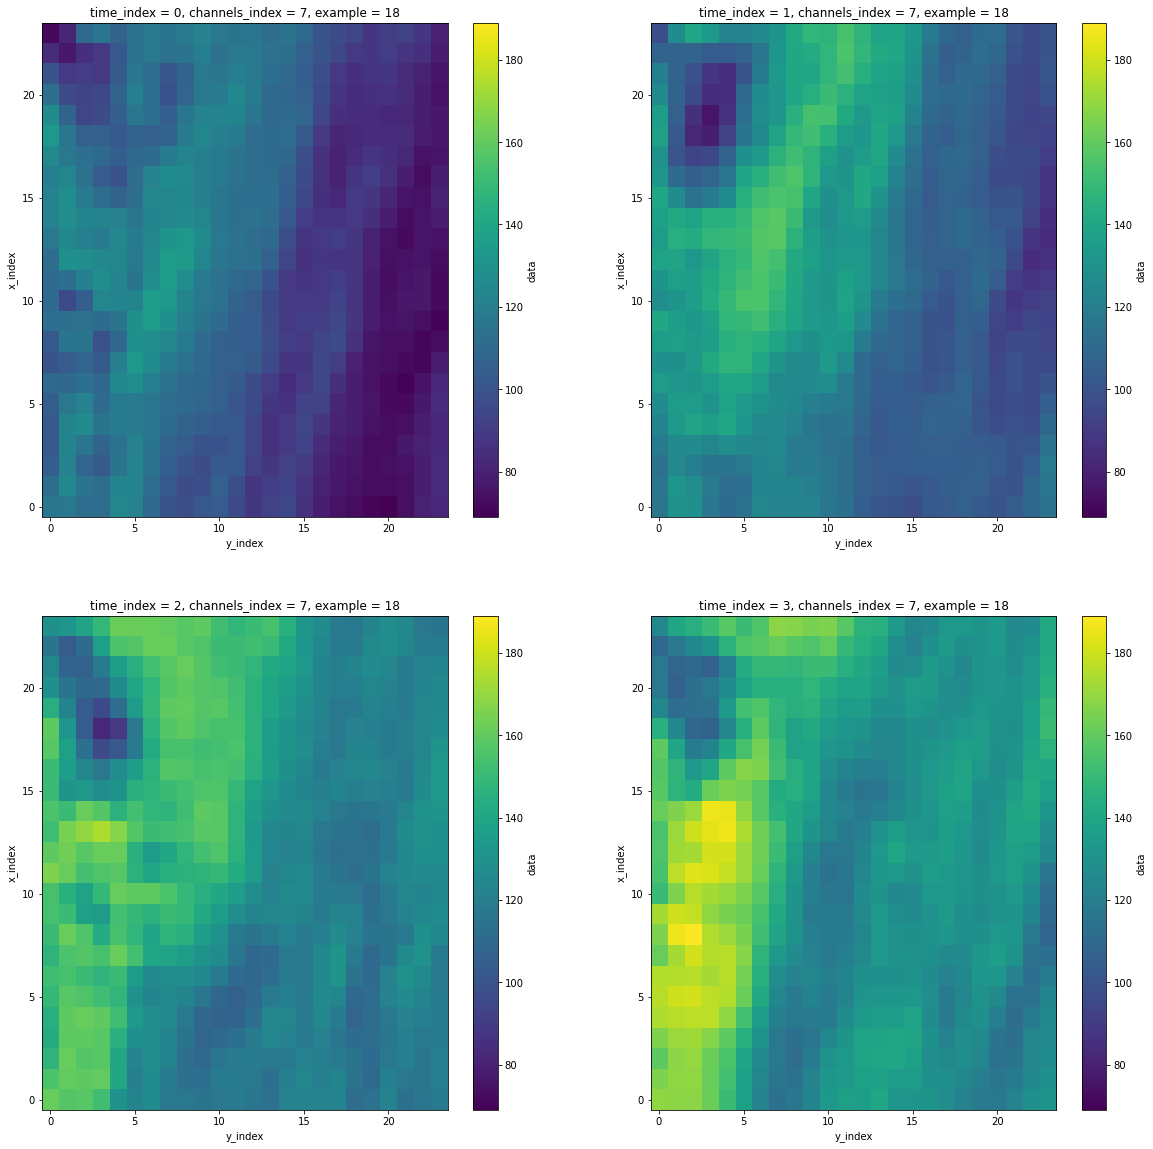

In [168]:
EXAMPLE_I = 18

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes = list(chain.from_iterable(axes))
data_to_plot = batch["satellite"].isel(
    example=EXAMPLE_I,
    channels_index=7
)
vmin = data_to_plot.min()
vmax = data_to_plot.max()
for time_index, ax in enumerate(axes):
    data_to_plot.isel(time_index=time_index).plot.imshow(ax=ax, vmin=vmin, vmax=vmax)

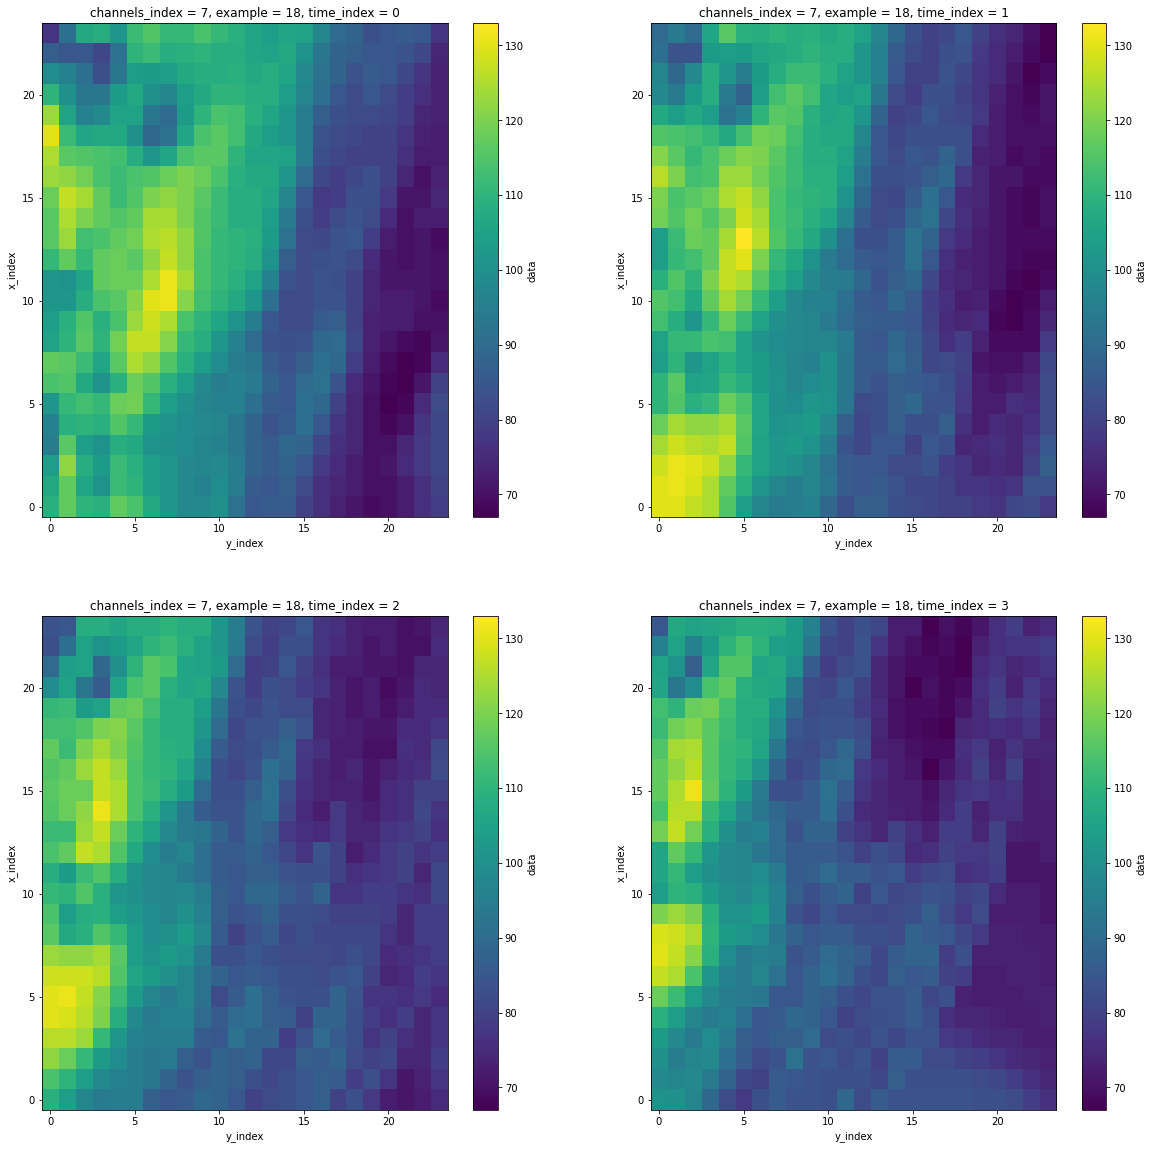

In [169]:
fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes = list(chain.from_iterable(axes))
data_to_plot = batch["opticalflow"].isel(
    example=EXAMPLE_I,
    channels_index=7
)
vmin = data_to_plot.min()
vmax = data_to_plot.max()
for time_index, ax in enumerate(axes):
    data_to_plot.isel(time_index=time_index).plot.imshow(ax=ax, vmin=vmin, vmax=vmax)

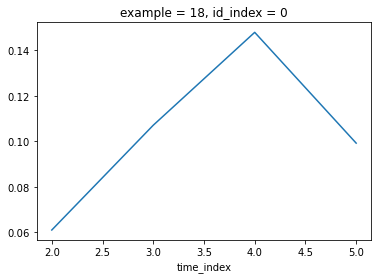

In [170]:
(batch["gsp"]["power_mw"] / batch["gsp"]["capacity_mwp"]).isel(example=EXAMPLE_I).plot()